# Truncated stick breaking in Greta

Here, we briefly discuss variational inference for truncated stick breaking (TSB). We use TSB as a finite-dimensional alternative to an infinite dimensional prior over number of mixture components. We do the analysis in R (cause the author is more comfortable with it). 

In this notebook we use an *error probability* likelihood.

Since we are mainly interested in speed of the inference, this notebook will sooner or later be translated to Edward2, because it has better support for VI than Stan or Greta.

Some required libraries:

In [1]:
suppressMessages(library("greta"))
suppressMessages(library("tensorflow"))
suppressMessages(library("rethinking"))
suppressMessages(library("rstan"))

In [2]:
suppressMessages(library("tidyverse"))
suppressMessages(library("coda"))
suppressMessages(library("bayesplot"))
suppressMessages(library("MASS"))

In [3]:
set.seed(23)

In [4]:
options(repr.plot.width=8, repr.plot.height=3)

In [80]:
N <- 1000
K <- 3
P <- 2

In [81]:
mus <- c(2, 5, 8)

In [82]:
data <- vector(length = N * K)
for (k in seq(K)) {    
    idx <- seq(N) + ((k - 1) * N)
    data[idx] <- rpois(N, mus[k])
}

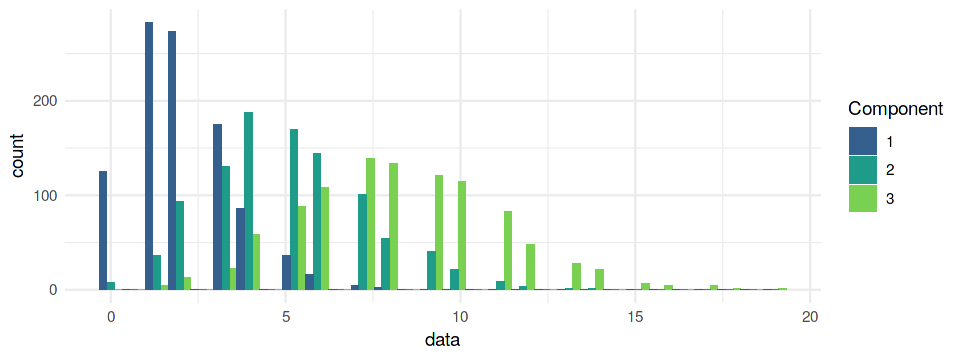

In [83]:
data.frame(data=data, idx=as.factor(rep(seq(K), each=N))) %>%
    ggplot(aes(data, fill=idx)) +
    geom_histogram(bins=30, position = "dodge") +
    scale_fill_viridis_d("Component", alpha = 1, begin=.3, end=.8) + 
    theme_minimal()

We truncate the DP at $K=10$ and define the model.

In [95]:
K <- 5

In [96]:
model.file <- "_models/tsb_poisson.stan"
cat(readLines(model.file), sep="\n")

data {
  int<lower=1> K;
  int<lower=1> N;	
  int x[N];	
}

parameters {    	
  ordered[K] mu;
  real<lower=0, upper=1> stick[K];
}

transformed parameters {  
  simplex[K] weights;

  weights[1] = stick[1];
  for(j in 2:(K-1)) 
  {
    weights[j] = stick[j] * (1 - stick[j - 1]) * weights[j - 1] / stick[j - 1]; 
  }
  weights[K] = 1 - sum(weights[1:(K - 1)]);
}

model {
  real mix[K];
  mu ~ uniform(0, 5);  	
  stick ~ beta(1, 1);	
	  
  for(i in 1:N) 
  {
    for(k in 1:K) 
    {
      mix[k] = log(weights[k]) + poisson_lpmf(x[i] | exp(mu[k]));
    }
    target += log_sum_exp(mix);
  }
}


In [97]:
stan.model <- rstan::stan_model(model.file)

In [98]:
stan_fit <- rstan::sampling(
    stan.model, data = list(K = as.integer(K), N = length(data), x = data),
    chains = 1)


SAMPLING FOR MODEL 'tsb_poisson' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 0.003419 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 34.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)


Warning message:
“There were 47 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [99]:
samples <- as.matrix(stan_fit)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


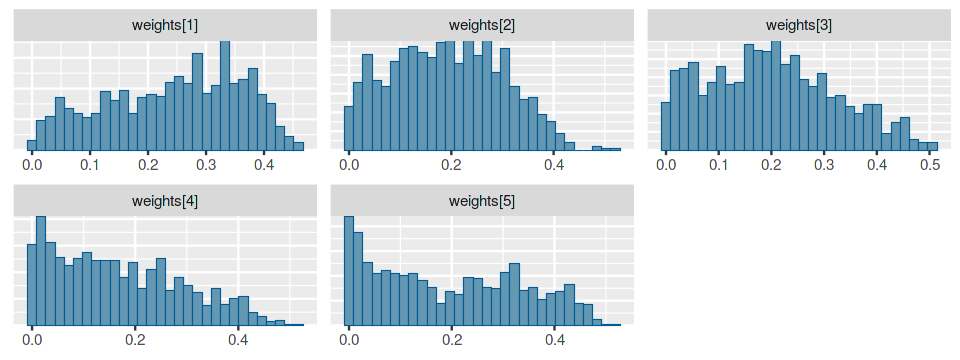

In [100]:
bayesplot::mcmc_hist(samples, regex_pars = "weights")

In [103]:
log(mus)

[1] 0.6931472 1.6094379 2.0794415

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


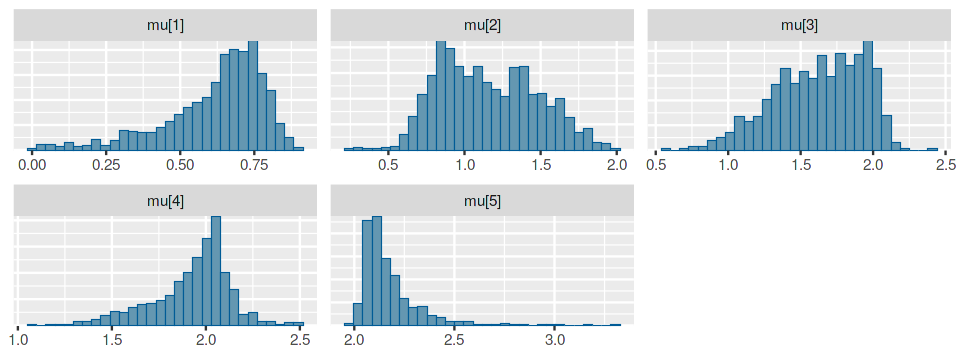

In [101]:
bayesplot::mcmc_hist(samples, regex_pars = "mu")

In [107]:
prior_mu_ordered <- cumsum(greta::variable(lower = 0, upper = 5, dim = K))

In [105]:
stick_breaking <- function(theta) {
   LaplacesDemon::Stick(theta)
}

# note the K - 1 which is required for LaplacesDemon::Stick (yes it's dumb)
prior_stick <- greta::beta(1, 1, dim = K - 1)
prior_weights <- stick_breaking(prior_stick)

In [108]:
greta::distribution(data) <- greta::mixture(
    greta::poisson(exp(prior_mu_ordered[1])),
    greta::poisson(exp(prior_mu_ordered[2])),
    greta::poisson(exp(prior_mu_ordered[3])),
    greta::poisson(exp(prior_mu_ordered[4])),
    greta::poisson(exp(prior_mu_ordered[5])),
    weights = prior_weights
)

In [110]:
mod <- greta::model(prior_stick, prior_weights, prior_mu_ordered)

In [113]:
samples <- greta::mcmc(
    mod,
    chains = 1,
    n_cores = 1
)

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


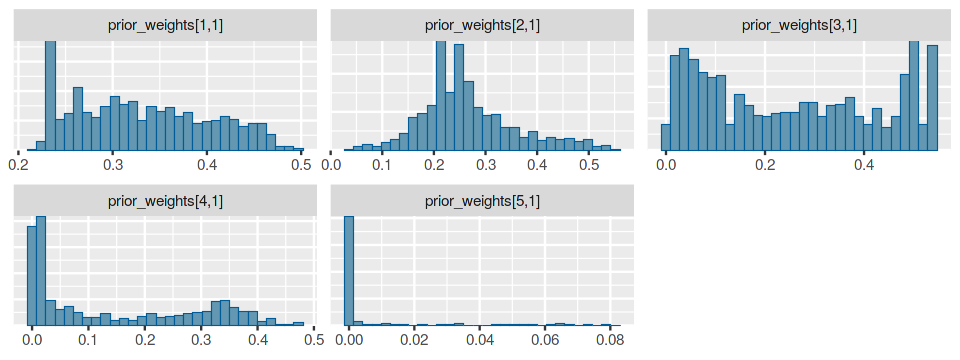

In [114]:
bayesplot::mcmc_hist(samples, regex_pars = "weights")

In [117]:
log(mus)

[1] 0.6931472 1.6094379 2.0794415

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


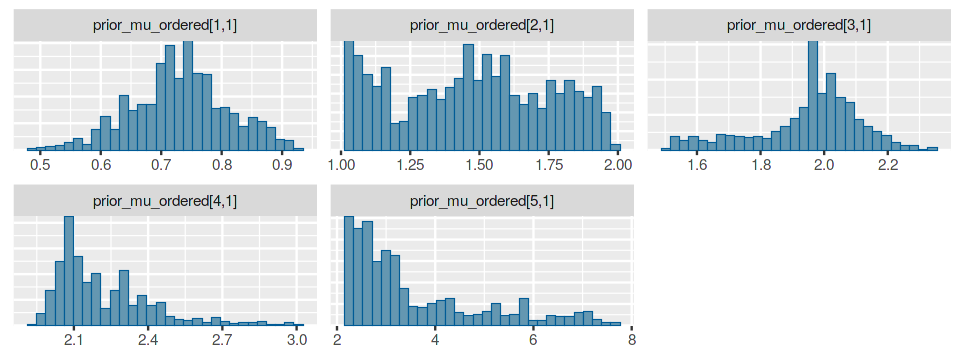

In [116]:
bayesplot::mcmc_hist(samples, regex_pars = "mu")

In [12]:
data <- matrix(0, N * K, P)
for (k in seq(K)) {
    for (n in seq(N)) {        
        idx <- n + ((k - 1) * N)        
        if (runif(1, 0, 1) > params["theta", k]) {
            data[idx,] <- rbinom(P, 1, 1 - params["beta", k])
        } else {                
            data[idx,] <- rbinom(P, 1, params["alpha", k])
        }
    }            
}

For the TSB, we use maximally $K=5$ components. Truncating the DP at some sufficiently high $K$ is enough to achieve a negligibly small error in comparison to a "true" infinite dimensional prior.

See for instance https://projecteuclid.org/euclid.bj/1551862850 for a theoretical and practical justification for the tunrcation.

In [14]:
K <- 5

In Greta we define priors like this. We use $K$ dimensional priors for every parameter, i.e. $\theta$, $\alpha$ and $\beta$

In [15]:
prior_theta <- greta::beta(1, 1, dim = K)
prior_beta <- greta::beta(1, 1, dim = K)
prior_alpha <- greta::beta(1, 1, dim = K)

Then we define the stick breaking construction. We set a prior on the second shape paramter of the Beta, even though this will probably not work.

In [16]:
stick_breaking <- function(prior_stick) {
    LaplacesDemon::Stick(prior_stick)
}

prior_shape <- greta::gamma(1, 1)
# note the K - 1 which is required for LaplacesDemon::Stick (yes it's dumb)
prior_stick <- greta::beta(1, prior_shape, dim = K - 1)
prior_weights <- stick_breaking(prior_stick)

This part is somewhat ugly in R. We define a common mixture with Greta and then need to manually add the components.
(this can be done way nice in Python with `*args`).

In [17]:
likelihood <- function(data, pt, pa, pb, pw) {
    distribution(data) <- greta::mixture(
        error_probability(pt[1], pa[1], pb[1]),
        error_probability(pt[2], pa[2], pb[2]),
        error_probability(pt[3], pa[3], pb[3]),
        error_probability(pt[4], pa[4], pb[4]),
        error_probability(pt[5], pa[5], pb[5]),
        weights = pw)
}

In [18]:
likelihood(data, prior_theta, prior_alpha, prior_beta, prior_weights)

Then we create the model.

In [19]:
mod <- greta::model(
    prior_theta, prior_beta, prior_alpha,
    prior_shape, prior_stick, prior_weights)

.. and sample from the posterior. To be able to do some diagnostics, we need at least two chains.

In [20]:
system.time(
    samples <- greta::mcmc(mod, chains = 2, n_cores = 2, n_samples = 2000)
)


running 2 chains simultaneously on up to 2 cores

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 2000/2000 | eta:  0s          


    user   system  elapsed 
4465.999   47.508 1455.101 

In [22]:
coda::gelman.diag(samples)

ERROR: Error in chol.default(W): the leading minor of order 24 is not positive definite


Whoops! For some reason (presumably poor mixing) there are numerical issues computing diagnostics for the posteriors. Let's still have a look at the posterior mixing weights. With these we can infer how many components we need.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


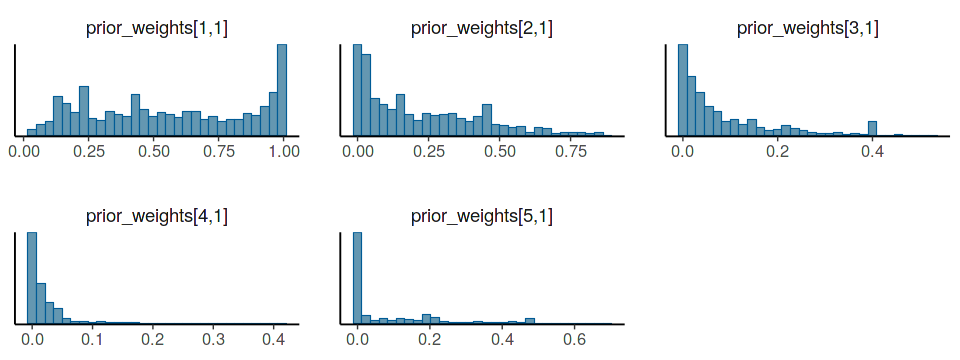

In [23]:
bayesplot::mcmc_hist(samples[[1]], regex_pars =  "weights")

Looks like three components is fine, just as we defined the data. Now let's look at all the parameters. We can do that concisely with an interval plot.

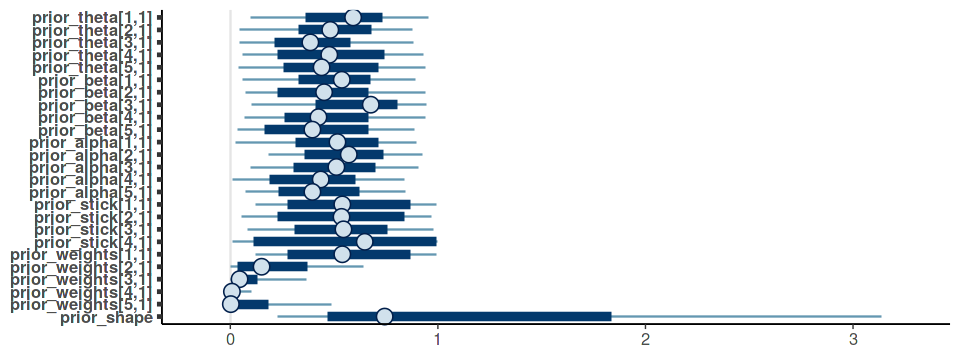

In [24]:
bayesplot::mcmc_intervals(samples[[1]])

It looks as the parameters fir a single component are not identifiable. At least all the medians are around $.5$. Since we used sufficiently large data and enough samples, it's safe to assume that the model is ill-defined.